In [1]:
import pandas as pd
import os

def load_housing_data(path='CaliforniaHousing/'):
    csv_path = os.path.join(path, 'housing.csv')
    return pd.read_csv(csv_path)

In [2]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

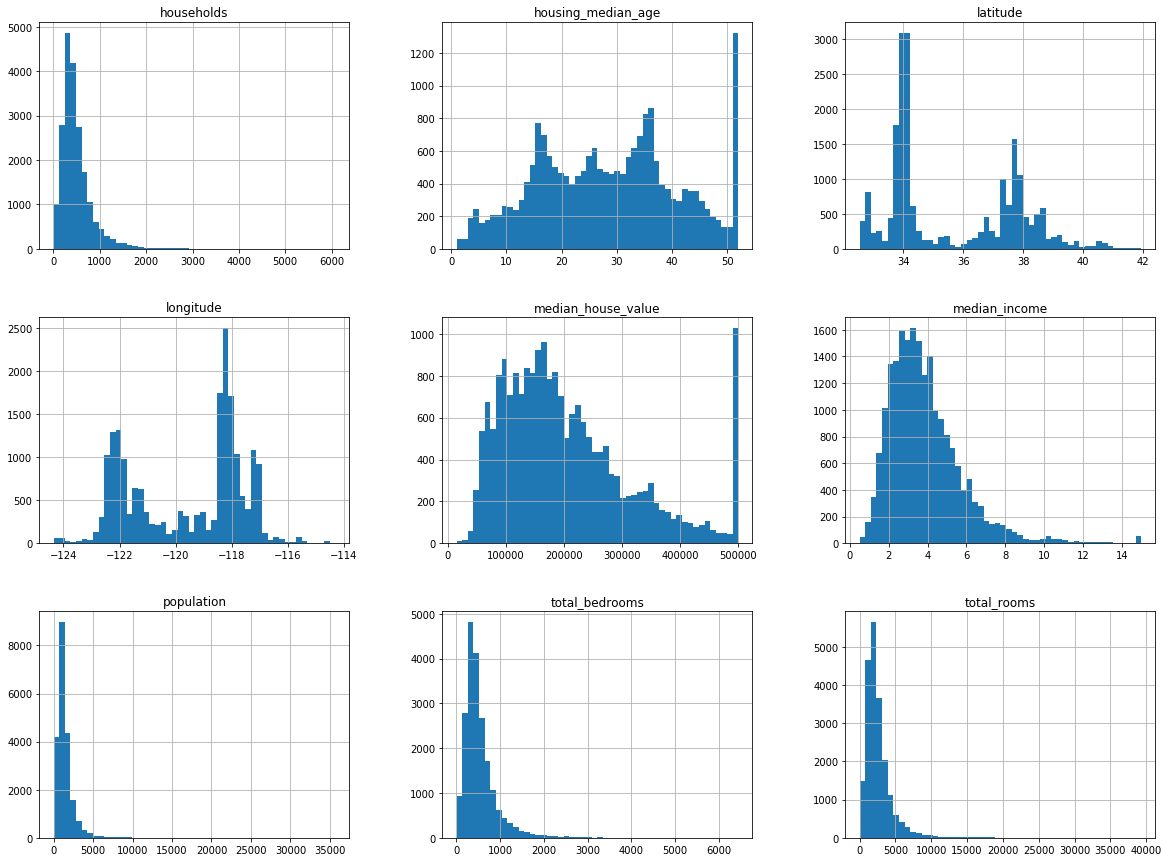

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [9]:
from zlib import crc32

def test_set_check(id, ratio):
    return crc32(np.int64(id)) & 0xffffffff < ratio * 2**32

def split_train_test_by_id(data, ratio, id_col):
    ids = data[id_col]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
print(len(train_set))
print(len(test_set))

16512
4128


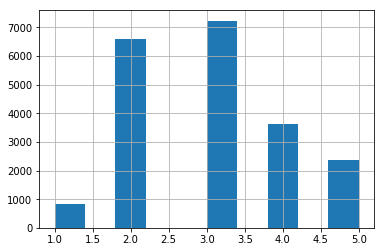

In [11]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)

# keep only categories lower than 5 and merging the other categories (i.e. those greater or equal to 5) into category 5
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

housing['income_cat'].hist()

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit as sss

split = sss(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [14]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [15]:
housing = strat_train_set.copy()

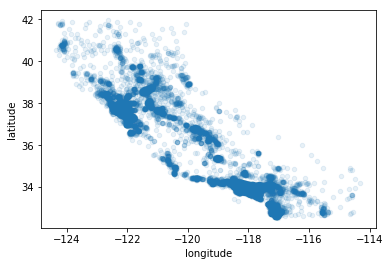

In [16]:
# visualising geographical data
housing.plot(kind='scatter', x='longitude', y ='latitude', alpha=.1)

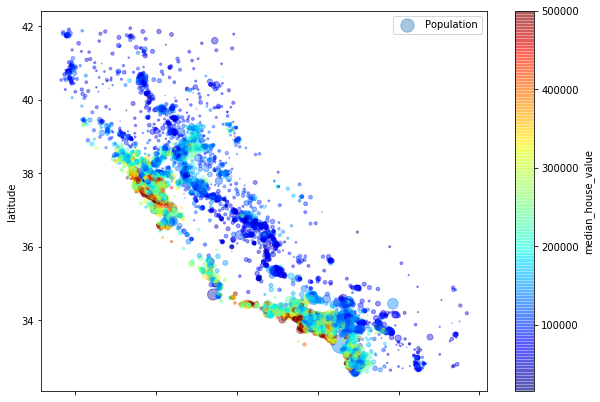

In [17]:
# visualising geographical data with price
housing.plot(kind='scatter', x='longitude', y ='latitude', alpha=.4,
             s=housing['population']/100,
             label='Population',
             figsize=(10,7),
             c='median_house_value',
             cmap=plt.get_cmap('jet'),
             colorbar=True)
plt.legend()

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5CE208668>,
      dtype=object)

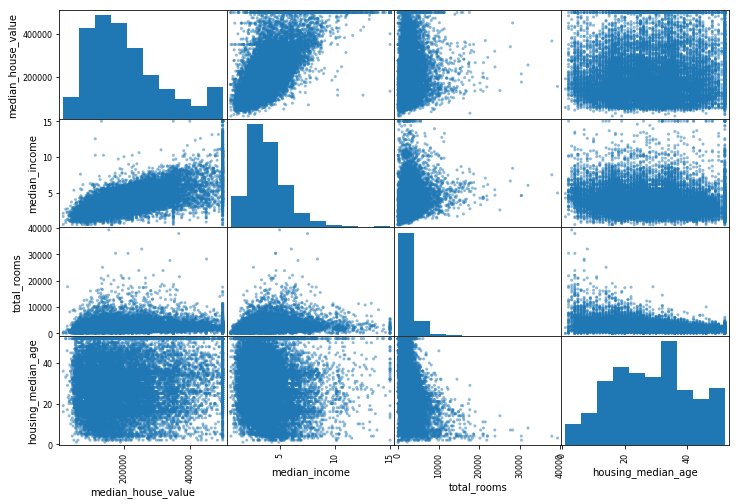

In [20]:
# plot few numerical attribute against other numerical ones
from pandas.plotting import scatter_matrix

attr = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attr], figsize=(12, 8))

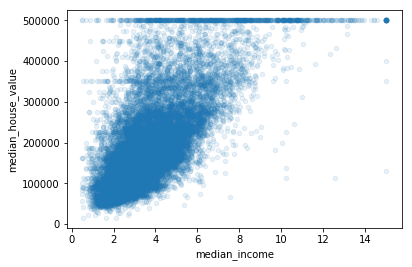

In [21]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=.1)

In [22]:
housing['room_per_household'] = housing['total_rooms'] / housing['households']
housing['bedroom_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [23]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
room_per_household          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_room           -0.259984
Name: median_house_value, dtype: float64

In [24]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [25]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [26]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [27]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [28]:
X = imputer.transform(housing_num)

In [29]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [30]:
housing_tr.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  
count    16512.000000  16512.000000  16512.000000   16512.000000  
mean       533.998123   1419.790819    497.060380       3.875589  
std        410.839621   1115.686241    375.720845       1.904950  
min          2.000000      3.000000      2.000000       0.499900  
25%        296.000000    784.000000    279.000000       2.566775  
50%        433.000000   1164.000000    408.000000       3.540900  
75%        641.000000   1719.250000    602.000000       4.744475  
max       6210.000000  35682.000000   5358.000000      15.000100

In [31]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [32]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [33]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [34]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder()

# housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
# housing_cat_1hot

In [35]:
# housing_cat_1hot.toarray()

In [36]:
from sklearn.preprocessing import OneHotEncoder 

cat_encoder = OneHotEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)

housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [37]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attrs = attr_adder.transform(housing.values)

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
                        ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr_names):
        self.attr_names = attr_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attr_names].values

In [49]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder())
])

In [50]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [52]:
housing_prepared = full_pipeline.fit_transform(housing)

print(housing_prepared)

  (0, 0)	-1.1560428086829155
  (0, 1)	0.7719496164846016
  (0, 2)	0.7433308916510305
  (0, 3)	-0.49323393384425046
  (0, 4)	-0.4454382074687401
  (0, 5)	-0.6362114070375079
  (0, 6)	-0.4206984222235789
  (0, 7)	-0.6149374443958345
  (0, 8)	-0.31205451913809157
  (0, 9)	-0.0864987054157523
  (0, 10)	0.15531753037148296
  (0, 11)	1.0
  (1, 0)	-1.1760248286103931
  (1, 1)	0.6596947951050618
  (1, 2)	-1.165317203353399
  (1, 3)	-0.9089665536785813
  (1, 4)	-1.036927797035715
  (1, 5)	-0.998331346653321
  (1, 6)	-1.0222270483369085
  (1, 7)	1.336459363533279
  (1, 8)	0.217683376839971
  (1, 9)	-0.03353391294213801
  (1, 10)	-0.8362890162005467
  (1, 11)	1.0
  (2, 0)	1.186849027813462
  :	:
  (16509, 12)	1.0
  (16510, 0)	0.7822131242821033
  (16510, 1)	-0.8510680092945644
  (16510, 2)	0.1866418639414053
  (16510, 3)	-0.30991876289367937
  (16510, 4)	-0.37484891488667316
  (16510, 5)	-0.05717803824588582
  (16510, 6)	-0.37545069371062934
  (16510, 7)	0.0981213859630686
  (16510, 8)	0.02499488

In [54]:
housing_prepared.shape

(16512, 16)

## Select and Train a Mode

In [55]:
# train a Linear Regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [57]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]

some_data_prepared = full_pipeline.transform(some_data)

print('Predictions:', lin_reg.predict(some_data_prepared))

print('Labels:', list(some_labels))

Predictions: [210644.60512293 317768.80742039 210956.43330839  59218.98785303
 189747.55854631]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [58]:
# measure linear regression model's RMSE on the whole training set

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848925

In [59]:
# train a decision tree regression model

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [60]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(lin_mse)
tree_rmse

0.0

In [64]:
# use K-fold cross validation to train the decision tree

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [65]:
def display_scores(scores):
    print('Scores', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [66]:
display_scores(tree_rmse_scores)

Scores [68083.55422634 68072.72133265 72461.98940115 69038.11679326
 70928.29168362 74625.61677647 71256.22512668 72399.16568026
 75515.59341607 69787.60642016]
Mean: 71216.88808566584
Standard deviation: 2441.815876689927


In [67]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [68]:
display_scores(lin_rmse_scores)

Scores [66782.73844082 66960.11805011 70347.95243662 74739.57053363
 68031.13387694 71193.84179828 64969.63057232 68281.61138001
 71552.91568652 67665.1007931 ]
Mean: 69052.46135683623
Standard deviation: 2731.6740043746886


In [69]:
# use random forest

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, housing_labels)

C:\Users\longt\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [70]:
housing_predictions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(lin_mse)
forest_rmse

0.0

In [71]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [72]:
display_scores(forest_rmse_scores)

Scores [51360.66460236 49286.45739164 51100.74563558 54625.76200846
 51873.76766666 56484.23491148 50565.5092293  51054.22936426
 56246.26620107 52091.18773063]
Mean: 52468.882474143116
Standard deviation: 2332.2194384752524


In [75]:
# fine tune model using grid search to find good combination of hyperparameter

from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [3, 10, 30],
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
        'max_features': [2, 3, 4]
    }
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [76]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [77]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [78]:
cvres = grid_search.cv_results_

In [79]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

65180.610343697175 {'max_features': 2, 'n_estimators': 3}
55593.22186855031 {'max_features': 2, 'n_estimators': 10}
52722.122027385376 {'max_features': 2, 'n_estimators': 30}
60097.90128901391 {'max_features': 4, 'n_estimators': 3}
53273.862895969716 {'max_features': 4, 'n_estimators': 10}
50667.08722665941 {'max_features': 4, 'n_estimators': 30}
59253.22303541906 {'max_features': 6, 'n_estimators': 3}
52377.27550155817 {'max_features': 6, 'n_estimators': 10}
50168.68916898381 {'max_features': 6, 'n_estimators': 30}
58475.98333336258 {'max_features': 8, 'n_estimators': 3}
52167.13734684087 {'max_features': 8, 'n_estimators': 10}
50145.00432937287 {'max_features': 8, 'n_estimators': 30}
62285.398540166905 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54435.52266423573 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60653.878502175416 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52894.27816585681 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [80]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.16228923e-02, 6.42286178e-02, 4.32762330e-02, 1.55516772e-02,
       1.53210611e-02, 1.54648786e-02, 1.44903751e-02, 3.37892818e-01,
       6.01875670e-02, 1.12794856e-01, 7.42979687e-02, 8.20348147e-03,
       1.59612768e-01, 7.11934357e-05, 2.54955945e-03, 4.43405240e-03])

In [81]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = cat_pipeline.named_steps['cat_encoder']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33789281841522906, 'median_income'),
 (0.15961276753875933, 'INLAND'),
 (0.11279485639301044, 'pop_per_hhold'),
 (0.07429796868926566, 'bedrooms_per_room'),
 (0.0716228923394549, 'longitude'),
 (0.06422861777051145, 'latitude'),
 (0.06018756700355724, 'rooms_per_hhold'),
 (0.043276233046550594, 'housing_median_age'),
 (0.015551677230083103, 'total_rooms'),
 (0.015464878580610287, 'population'),
 (0.015321061131705423, 'total_bedrooms'),
 (0.01449037509829951, 'households'),
 (0.00820348147391686, '<1H OCEAN'),
 (0.004434052403600547, 'NEAR OCEAN'),
 (0.0025495594497597384, 'NEAR BAY'),
 (7.119343568573884e-05, 'ISLAND')]

In [82]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)

y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_prediction = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_prediction)

final_rmse = np.sqrt(final_mse)

final_rmse

47976.997172114796